In [661]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.preprocessing import Normalizer
import graphviz
import seaborn as sns
%matplotlib inline

# Starbucks Project

## 1. Business Understanding

It is important for chain stores for consumers like Starbucks to **make effective promotion offers** to its customers. As promotion offers incur certain cost, they should be spent only for customers who will become loyal customers of Starbucks. Being that said, Starbucks needs to know **what kind of offers are "effective" for what kind of customers.** Luckily, here we have a set of data from Starbucks which is provided for capstone project for Udacity Data Science Nano-degree program. With the data set, we will explore;  
 - **Which groups of people are most responsive to each type of offer?**
 - **How best to present each type of offer?**


## 2. Data Understanding

### Data Set
Here we have three data files.
- **portfolio.json** - information about offers
- **profile.json** - information about customers
- **transcript.json** -  data containing four types of transactions - (1)purchases, (2)offers received, (3)offers viewed and (4)offers completed.

We will review each file one by one.

#### Offers

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [558]:
# Loading offers from portfolio.json
offers = pd.read_json("data/portfolio.json", orient="records", lines=True)
print(offers.shape)
offers.head()

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


#### Customers

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [12]:
# Loading customers from profile.json
customers = pd.read_json("data/profile.json", orient="records", lines=True)
print(customers.shape)
customers.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


#### Transactions

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [14]:
trans = pd.read_json("data/transcript.json", orient="records", lines=True)
print(trans.shape)
purchases = trans[trans["event"]=="transaction"]
offers_received = trans[trans["event"]=="offer received"]
offers_viewed = trans[trans["event"]=="offer viewed"]
offers_completed = trans[trans["event"]=="offer completed"]

(306534, 4)


## 3. Data Preparation (common)

We will process data cleaning and preparation in this section such as filling missing values from other formats, extracting values, as well as creating bins.

#### 3.1. Customer Attributes

In [24]:
# Filling missing values in Gender with "Unknown"
customers["gender"] = customers["gender"].fillna(value="Unknown")
customers["gender"].value_counts(dropna=False)

M          8484
F          6129
Unknown    2175
O           212
Name: gender, dtype: int64

In [25]:
# Filling missing values in Income with 0
customers["income"] = customers["income"].fillna(value=0)
customers["income"].value_counts(dropna=False)

0.0         2175
73000.0      314
72000.0      297
71000.0      294
57000.0      288
            ... 
116000.0      46
112000.0      45
107000.0      45
117000.0      32
120000.0      13
Name: income, Length: 92, dtype: int64

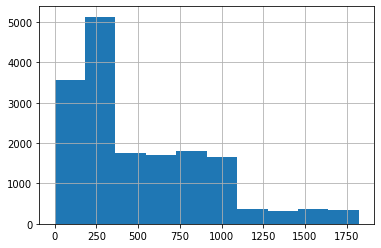

In [22]:
# Getting Membership Duration by # of Days
current_date = pd.to_datetime(customers["became_member_on"], format="%Y%m%d").max()
customers["membership_duration"] = (current_date - pd.to_datetime(customers["became_member_on"], format="%Y%m%d")).dt.days
customers["membership_duration"].hist()

In [42]:
# Creating Age Bin
customers["age_bin"] = pd.cut(customers["age"],bins=[0,10,20,30,40,50,60,70,80,90,120])
customers["age_bin"].value_counts()

(50, 60]     3590
(60, 70]     2910
(90, 120]    2394
(40, 50]     2391
(70, 80]     1646
(30, 40]     1597
(20, 30]     1365
(80, 90]      767
(10, 20]      340
(0, 10]         0
Name: age_bin, dtype: int64

In [40]:
# Creating Income Bin
customers["income_bin"] = pd.cut(customers["income"],bins=10)
customers["income_bin"].value_counts()

(48000.0, 60000.0]      3069
(60000.0, 72000.0]      2938
(36000.0, 48000.0]      2287
(72000.0, 84000.0]      2179
(-120.0, 12000.0]       2175
(84000.0, 96000.0]      1563
(24000.0, 36000.0]      1337
(96000.0, 108000.0]      872
(108000.0, 120000.0]     580
(12000.0, 24000.0]         0
Name: income_bin, dtype: int64

In [43]:
# Creating Membership Duration Bin
customers["membership_duration_bin"] = pd.cut(customers["membership_duration"],bins=10)
customers["membership_duration_bin"].value_counts()

(182.3, 364.6]      5135
(-1.823, 182.3]     3556
(729.2, 911.5]      1795
(364.6, 546.9]      1748
(546.9, 729.2]      1715
(911.5, 1093.8]     1658
(1458.4, 1640.7]     362
(1093.8, 1276.1]     362
(1640.7, 1823.0]     343
(1276.1, 1458.4]     326
Name: membership_duration_bin, dtype: int64

#### 4.2. Transactions

In [32]:
# Extracting amount from purchase transaction
purchases.loc[:,"amount"] = purchases.loc[:,"value"].apply(lambda v:v["amount"]).values
purchases["amount"].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [38]:
# Extracting offer id from offers received
offers_received.loc[:,"offer id"] = offers_received.loc[:,"value"].apply(lambda v:v["offer id"])
offers_received["offer id"].value_counts()

9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
ae264e3637204a6fb9bb56bc8210ddfd    7658
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
5a8bc65990b245e5a138643cd4eb9837    7618
3f207df678b143eea3cee63160fa8bed    7617
fafdcd668e3743c1bb461111dcafc2a4    7597
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
f19421c1d4aa40978ebb69ca19b0e20d    7571
Name: offer id, dtype: int64

In [37]:
# Extracting offer id from offers completed
offers_completed.loc[:,"offer id"] = offers_completed.loc[:,"value"].apply(lambda v:v["offer_id"])
offers_completed["offer id"].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    5317
2298d6c36e964ae4a3e7e9706d1fb8c2    5156
9b98b8c7a33c4b65b9aebfe6a799e6d9    4354
f19421c1d4aa40978ebb69ca19b0e20d    4296
2906b810c7d4411798c6938adc9daaa5    4017
ae264e3637204a6fb9bb56bc8210ddfd    3688
0b1e1539f2cc45b7b9fa7c272da2e1d7    3420
4d5c57ea9a6940dd891ad53e9dbe8da0    3331
Name: offer id, dtype: int64

## 4. Which groups of people are most responsive to each type of offer?

Firstly we will explore which group of customers respond to offers best. For now, let's focus on **BOGO offers** and find patterns.  
To classify customers into groups, we will try three approaches (**Attributes, Clustering and Decision Tree**) and consider which one is the best.

### 4.1. Attributes

We will look at how customers respond to offers differently ascross different attribute groups. The attributes to be reviewed inlcude **gender**, **age**, **income** as well as **membership duration**.

In [704]:
def conversion_by_attr(attr, offer_type="bogo", customers=customers):
    """
    This function filters offers received, offers completed and customer data with an offer type specified
    and aggregates it by an attribute passed as parameter.
    Params:
        attr(): an attribute by which data is to be aggregated
        offer_type(): a type of offer by with which offer data is to be filtered
        customers: customer data with attributes which is to be joined to offer data
    Return:
        conv_by_attr(): offers aggreated by an attribute which is passed as a parameter 
    """
    # Filtering offers by offer_type
    offers_filtered = offers[offers["offer_type"]==offer_type]
    offers_received_filtered = pd.merge(offers_received, offers_filtered, left_on="offer id", right_on="id")
    offers_completed_filtered = pd.merge(offers_completed, offers_filtered, left_on="offer id", right_on="id")

    # Grouping by an attribute
    offers_received_grouped_by_attr = pd.merge(
        offers_received_filtered, customers, left_on="person", right_on="id").groupby(by=attr)["offer id"].count()
    offers_completed_grouped_by_attr = pd.merge(
        offers_completed_filtered, customers, left_on="person", right_on="id").groupby(by=attr)["offer id"].count()

    # Merging offers received and offers completed
    conv_by_attr = pd.merge(
        offers_received_grouped_by_attr, offers_completed_grouped_by_attr, on=attr,how="left")

    # Calculating conversion rate
    conv_by_attr.columns=["num_received", "num_completed"]
    conv_by_attr["conversion_rate"]=conv_by_attr["num_completed"]/conv_by_attr["num_received"]
    
    return conv_by_attr


#### By Gender

As shown below, **female customers are more likely to respond to offers** than male customers. (**68%** vs. **49%**) It should be also noted that there are certain number of customers whose gender is unknown (and conversion rate is as low as 10%)

,num_received,num_completed,conversion_rate
gender,,,
F,10975,7501,0.683462
M,15208,7512,0.493951
O,354,245,0.692090
Unknown,3962,411,0.103735


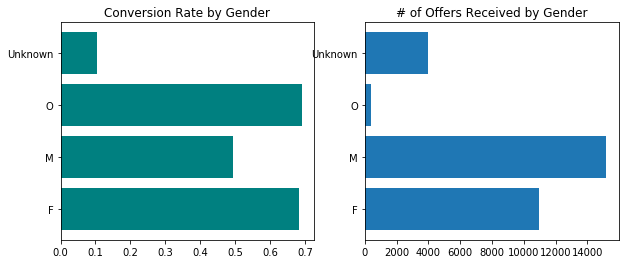

In [705]:
conv_by_gender = conversion_by_attr("gender")
f, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].barh(y=conv_by_gender.index, width=conv_by_gender["conversion_rate"], color="teal")
axes[0].set_title("Conversion Rate by Gender")
axes[1].barh(y=conv_by_gender.index, width=conv_by_gender["num_received"])
axes[1].set_title("# of Offers Received by Gender")
conv_by_gender

#### By Age

As shown bleow, **the older customers are, the more likely they are to respond to offers** in general. It should also noted that there are certain number of customers whose age is 118 which we believe is unknown data, instead of actual elderly who are 118 years old.

,num_received,num_completed,conversion_rate
age_bin,,,
"(0, 10]",0,0,NaN
"(10, 20]",637,244,0.383046
"(20, 30]",2440,1066,0.436885
"(30, 40]",2833,1439,0.507942
"(40, 50]",4309,2448,0.568113
"(50, 60]",6420,3991,0.621651
"(60, 70]",5218,3130,0.599847
"(70, 80]",2944,1819,0.617867
"(80, 90]",1326,865,0.652338


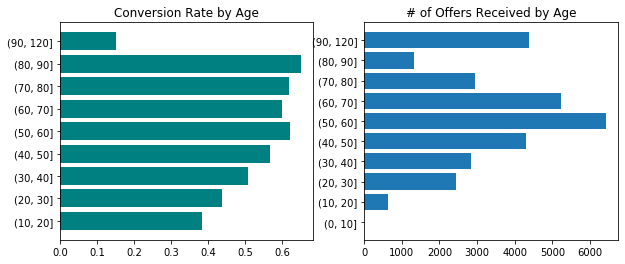

In [706]:
conv_by_age = conversion_by_attr("age_bin")
f, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].barh(y=conv_by_age.index.astype(str), width=conv_by_age["conversion_rate"], color="teal")
axes[0].set_title("Conversion Rate by Age")
axes[1].barh(y=conv_by_age.index.astype(str), width=conv_by_age["num_received"])
axes[1].set_title("# of Offers Received by Age")
conv_by_age

In [712]:
print(customers["age"][customers["age"]>=90].value_counts())
print(customers[customers["age"]>=90].shape)

118    2175
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
101       5
99        5
98        5
Name: age, dtype: int64
(2446, 9)


#### By Income

**The higher customers' income is, the more likely customers are to respond to offers** than others in general.

,num_received,num_completed,conversion_rate
income_bin,,,
"(-120.0, 12000.0]",3962,411,0.103735
"(12000.0, 24000.0]",0,0,NaN
"(24000.0, 36000.0]",2436,891,0.365764
"(36000.0, 48000.0]",4070,1623,0.398771
"(48000.0, 60000.0]",5506,2966,0.538685
"(60000.0, 72000.0]",5219,3039,0.582295
"(72000.0, 84000.0]",3837,2649,0.690383
"(84000.0, 96000.0]",2839,2094,0.737584
"(96000.0, 108000.0]",1538,1174,0.763329


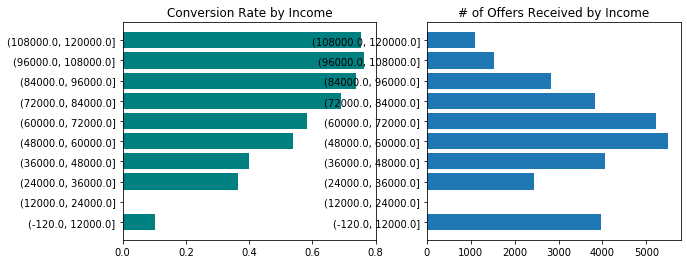

In [707]:
conv_by_income = conversion_by_attr("income_bin")
f, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].barh(y=conv_by_income.index.astype(str), width=conv_by_income["conversion_rate"], color="teal")
axes[0].set_title("Conversion Rate by Income")
axes[1].barh(y=conv_by_income.index.astype(str), width=conv_by_income["num_received"])
axes[1].set_title("# of Offers Received by Income")
conv_by_income

#### By Membership Duration

Customers whose **membership duration falls between approximately 1 year to 3 years (365 days to 1094 days)** are more likely to respond to offers than other groups. (**68-71%** vs. **less than 46%**)

,num_received,num_completed,conversion_rate
membership_duration_bin,,,
"(-1.823, 182.3]",6359,1960,0.308225
"(182.3, 364.6]",9250,4008,0.433297
"(364.6, 546.9]",3176,2219,0.698678
"(546.9, 729.2]",3010,2144,0.712292
"(729.2, 911.5]",3166,2202,0.695515
"(911.5, 1093.8]",3023,2059,0.681111
"(1093.8, 1276.1]",657,305,0.464231
"(1276.1, 1458.4]",582,228,0.391753
"(1458.4, 1640.7]",637,263,0.412873


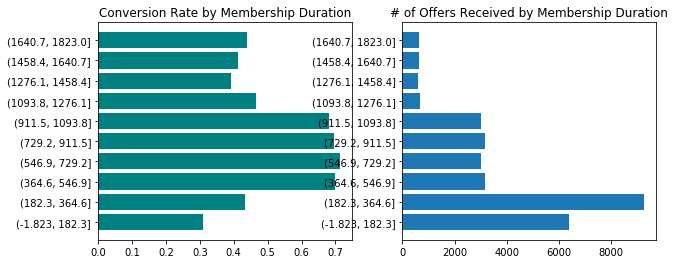

In [708]:
conv_by_duration = conversion_by_attr("membership_duration_bin")
f, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].barh(y=conv_by_duration.index.astype(str), width=conv_by_duration["conversion_rate"], color="teal")
axes[0].set_title("Conversion Rate by Membership Duration")
axes[1].barh(y=conv_by_duration.index.astype(str), width=conv_by_duration["num_received"])
axes[1].set_title("# of Offers Received by Membership Duration")
conv_by_duration

### 4.2. Clustering (KMeans)

As the second option, we will try clustering with k-means as an unsupervised machine learning approach. The idea is to identify how different groups of customers, who are classified based on their demographics, respond to offers differently.

### 4.2.1. Data Preparation

In [580]:
# Processing features. Numberical attributes are used as they are, while categorical attributes are 
# converted with one-hot encoding.
X = customers[["age", "income", "membership_duration"]]
X = pd.concat([X, pd.get_dummies(customers["gender"])], axis=1)

# Normalizing features for clustering
X_normalized = Normalizer().fit(X.transpose()).transform(X.transpose()).transpose()

print(X.head())
print(pd.DataFrame(X_normalized).head())

   age    income  membership_duration  F  M  O  Unknown
0  118       0.0                  529  0  0  0        1
1   55  112000.0                  376  1  0  0        0
2  118       0.0                   14  0  0  0        1
3   75  100000.0                  443  1  0  0        0
4  118       0.0                  356  0  0  0        1
          0         1         2         3    4    5         6
0  0.013308  0.000000  0.006139  0.000000  0.0  0.0  0.021442
1  0.006203  0.013355  0.004363  0.012773  0.0  0.0  0.000000
2  0.013308  0.000000  0.000162  0.000000  0.0  0.0  0.021442
3  0.008458  0.011924  0.005141  0.012773  0.0  0.0  0.000000
4  0.013308  0.000000  0.004131  0.000000  0.0  0.0  0.021442


### 4.2.2. Modeling

,num_received,num_completed,conversion_rate
cluster,,,
1,2572,231,0.089813
9,1390,180,0.129496
0,6170,1980,0.320908
3,1638,667,0.407204
2,3831,2186,0.570608
8,3524,2059,0.584279
4,354,245,0.692090
5,3604,2512,0.697003
6,3876,2806,0.723942


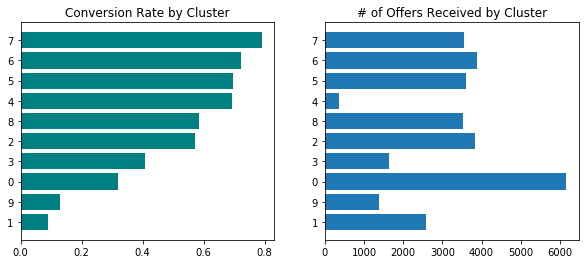

In [721]:
# Building clusters with k-means
clf = KMeans(n_clusters=10, random_state=42)
clf.fit(X_normalized)
clusters = clf.predict(X_normalized)

# Combining clusters calculated and customer list
customers_clustered = pd.concat([customers, pd.Series(clusters, name="cluster")], axis=1)

# Aggregating offers by the clusters just calculated
conv_by_cluster = conversion_by_attr("cluster", customers=customers_clustered).sort_values(by="conversion_rate")

# Visualizing distribution of clusters
f, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].barh(y=conv_by_cluster.index.astype(str), width=conv_by_cluster["conversion_rate"], color="teal")
axes[0].set_title("Conversion Rate by Cluster")
axes[1].barh(y=conv_by_cluster.index.astype(str), width=conv_by_cluster["num_received"])
axes[1].set_title("# of Offers Received by Cluster")
conv_by_cluster

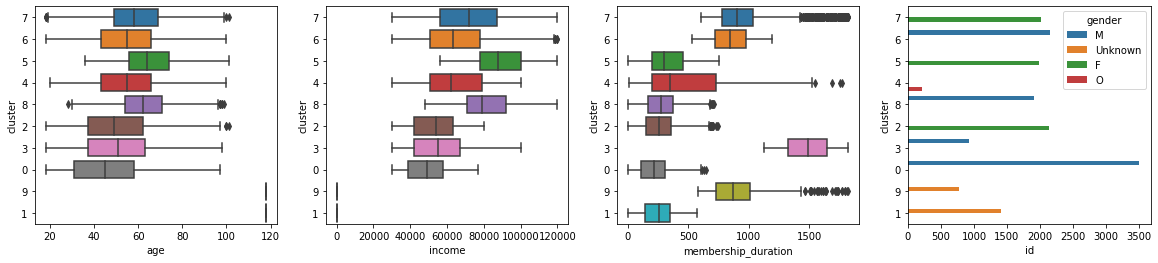

In [722]:
# Sotring clusters by conversion ratio
cluster_order = conv_by_cluster.sort_values("conversion_rate", ascending=False).index

# Visualizaing how attributes of clusters are distributed
f, axes = plt.subplots(ncols=4, figsize=(20,4))
sns.boxplot(x="age",y="cluster",data=customers_clustered,orient="h",order=cluster_order, ax=axes[0])
sns.boxplot(x="income",y="cluster",data=customers_clustered,orient="h",order=cluster_order, ax=axes[1])
sns.boxplot(x="membership_duration",y="cluster",data=customers_clustered,orient="h",order=cluster_order, ax=axes[2])

cust_by_cluster_gender = customers_clustered.groupby(by=["cluster","gender"])["id"].count().reset_index()
sns.barplot(x="id",y="cluster",hue="gender", data=cust_by_cluster_gender,orient="h",order=cluster_order, ax=axes[3])

In [ ]:
customers_clustered["age"].describe

Below is description of each cluster:  
- **Higher group**:
 - **Cluster 7(79%):** female customers whose membership duration is around 2 years or longer.
 - **Cluster 6(72%):** male customers whose membership duration is around 2-4 years.
 - **Cluster 5(70%):** female customers whose income is at higher range and membership duration is mostly less than 2 years.
 - **Cluster 4(69%):** customers whose gender is unknown. (only small number of customers belong to this group)
- **Middle group**:
 - **Cluster 8(58%):** male customers with higher income and membership duration is mostly less than 2 years.
 - **Cluster 2(57%):** female customers whose membership duration is mostly less than 2 years.
- **Lower group**:
 - **Cluster 0(41%):** male customers whose membership duration is more than 3 years.
 - **Cluster 3(32%):** male customers with lower income and membership duration is mostly less than 2 years.
 - **Cluster 9(13%):** customers whose gender is unknown and mmebership duration is more than 2 years.
 - **Cluster 1( 9%):** customers whose gender is unknown and mmebership duration is less than 2 years.

### 4.3. Decision Tree

The third option is building decision tree model.

### 4.3.1. Data Preparation

Note : In building the decision tree model, offers will be aggregated by customer, instead of using it at individual offer level. This is because offers received and offers completed cannot be connected via unique key. In case of multiple offers being received by a single customer, offers are considered as "completed" if at least one offer is completed.

In [278]:
# Filtering offers by offer_type
offer_type = "bogo"
offers_filtered = offers[offers["offer_type"]==offer_type]
offers_received_filtered = pd.merge(offers_received, offers_filtered, left_on="offer id", right_on="id")
offers_completed_filtered = pd.merge(offers_completed, offers_filtered, left_on="offer id", right_on="id")

# Series of customer id who completed at least one BOGO offer
customer_id_completed = offers_completed_filtered.groupby(by="person").all().index

# Identify if customer completed offer and get boolean series
y = customers["id"].agg(lambda i: i in customer_id_completed)


### 4.3.2. Modeling

In [728]:
# Building decision tree model
dtc = DecisionTreeClassifier(max_depth=5,min_samples_leaf=0.05, random_state=42)
dtc.fit(X, y)

# Visualizing decision tree
dot_data = export_graphviz(
    dtc,
    out_file="tree.dot",
    feature_names=X.columns,
    class_names=["not completed","completed"],
    filled=True,
    proportion=True,
    node_ids=True)
graphviz.Source(dot_data)

Generating description of each leaf nodes.

In [648]:
# getting leaf nodes
# Reference URL https://qiita.com/kotaRof/items/c478a5ae4c2f70148bf4
leaf_nodes = []
for node_id in range(dtc.tree_.node_count):
    if dtc.tree_.children_left[node_id] < 0 and dtc.tree_.children_right[node_id] <0:
        leaf_nodes.append(node_id)

# Creating a DataFrame which describes structure of decision tree
nodes = pd.DataFrame(index=range(dtc.tree_.node_count))
nodes["feature"] = dtc.tree_.feature
nodes["threshold"] = dtc.tree_.threshold
nodes["value0"] = dtc.tree_.value[:,0,0]
nodes["value1"] = dtc.tree_.value[:,0,1]
nodes["children_left"] = dtc.tree_.children_left
nodes["children_right"] = dtc.tree_.children_right
nodes["n_node_samples"] = dtc.tree_.n_node_samples
nodes["conversion_rate"] = nodes["value1"]/(nodes["value1"] + nodes["value0"])
nodes["is_leaf"] = [nodes.loc[i]["children_left"] < 0 and nodes.loc[i]["children_right"] < 0 for i in nodes.index]
# nodes["description"] = None

In [649]:
nodes.head()

,feature,threshold,value0,value1,children_left,children_right,n_node_samples,conversion_rate,is_leaf
0,1,49500.0,7737.0,9263.0,1,10,17000,0.544882,False
1,1,15000.0,3951.0,2005.0,2,5,5956,0.336635,False
2,2,330.5,1826.0,349.0,3,4,2175,0.160460,False
3,-2,-2.0,877.0,99.0,-1,-1,976,0.101434,True
4,-2,-2.0,949.0,250.0,-1,-1,1199,0.208507,True


In [650]:
nodes[nodes["is_leaf"]].sort_values("conversion_rate",ascending=False)

,feature,threshold,value0,value1,children_left,children_right,n_node_samples,conversion_rate,is_leaf
26,-2,-2.0,252.0,1266.0,-1,-1,1518,0.833992,True
27,-2,-2.0,288.0,1203.0,-1,-1,1491,0.806841,True
24,-2,-2.0,210.0,730.0,-1,-1,940,0.776596,True
23,-2,-2.0,211.0,646.0,-1,-1,857,0.753792,True
19,-2,-2.0,260.0,606.0,-1,-1,866,0.699769,True
18,-2,-2.0,341.0,576.0,-1,-1,917,0.628135,True
28,-2,-2.0,328.0,553.0,-1,-1,881,0.627696,True
13,-2,-2.0,596.0,769.0,-1,-1,1365,0.563370,True
9,-2,-2.0,681.0,871.0,-1,-1,1552,0.561211,True
16,-2,-2.0,581.0,502.0,-1,-1,1083,0.463527,True


Top and bottom of groups are as follows:
- **Higher group** (conversion rate > 70%) #26,#27,#24,#23:
 - #21(#23,#24,#26,#27):conversion rate is **80.0%**:Income is more than 49,500 and membership duration is between 364.5 and 1,099.5
- **Lower group** (conversion rate < 40%) #8,#15,#7,#4,#3:
 - #2(#3,#4):conversion rate is **16.0%**:Income is less than 15,000
 - #6(#7,#8):conversion rate is **35.2%**:Income is between 15,000 and 49,500 and membership duration is less than 366.5
 - #15:**36.1%**:Income is between 49,500 and 76,500 and membership duration is less than 203.5 and gender is not male (female, others and unknown)

While we focused on **BOGO** offer above, we could apply the same approach to explore the most and least responsive customers for **Discount** offers.

## 5. How best to present each type of offer?

In order to present offers to customers effectively, we should send each type of offer to customers who like it. In other words, we should send each type of offer to **customers who are very likely to respond** to the offer.  
To achieve the goal, we will build **machine learning models which predict probability of customers completing offers**.  

We will try algorithms for supervised learning of binary classification such as **Logistic Regression**, **Decision Tree**, **Random Forest** etc. Again, we will focus on **BOGO** offers for now.

### 5.1. Data Preparation

We will build one-hot-encoded explanatory variables for some of algorithms.

In [410]:
# Generating X with one-hot-encoding
X_onehot = pd.get_dummies(customers[["gender", "age_bin", "income_bin", "membership_duration_bin"]])
X_onehot.head()

,gender_F,gender_M,gender_O,gender_Unknown,"age_bin_(0, 10]","age_bin_(10, 20]","age_bin_(20, 30]","age_bin_(30, 40]","age_bin_(40, 50]","age_bin_(50, 60]",...,"membership_duration_bin_(-1.823, 182.3]","membership_duration_bin_(182.3, 364.6]","membership_duration_bin_(364.6, 546.9]","membership_duration_bin_(546.9, 729.2]","membership_duration_bin_(729.2, 911.5]","membership_duration_bin_(911.5, 1093.8]","membership_duration_bin_(1093.8, 1276.1]","membership_duration_bin_(1276.1, 1458.4]","membership_duration_bin_(1458.4, 1640.7]","membership_duration_bin_(1640.7, 1823.0]"
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### 5.2. Modeling

#### 5.2.1. Logistic Regression

In [741]:
# Building a model with one-hot variables
param_grid = {
    "penalty":["l2"],
    "dual":[False],
    "solver":["newton-cg","lbfgs","liblinear","sag","saga"]
}
estimator = LogisticRegression(random_state=42)
search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
search.fit(X_onehot,y)
print(search)

# Getting accuracy of the model
print(cv_results["test_score"])
print(np.mean(cv_results["test_score"]))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'dual': [False], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
[0.69744193 0.70626286 0.69558824 0.70167696 0

#### 5.2.1. Decision Tree

In [730]:
# Building a model
param_grid = {
    "criterion":["gini","entropy"],
    "max_depth":[3,4,5,6],
    "min_samples_leaf":[0.01,0.05]}
estimator = DecisionTreeClassifier(random_state=42)
search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
search.fit(X,y)
print(search)

# Evaluating results
print(search.cv_results_["mean_test_score"])
print(np.max(search.cv_results_["mean_test_score"]))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'm

#### 5.2.2. Random Forrest

In [731]:
# Building a model
param_grid = {
    "criterion":["gini","entropy"],
    "max_depth":[3,4,5,6],
    "min_samples_leaf":[0.01,0.05],
    "n_estimators":[10,100]}
estimator = RandomForestClassifier(random_state=42)
search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
search.fit(X,y)
print(search)

# Evaluating results
print(search.cv_results_["mean_test_score"])
print(np.max(search.cv_results_["mean_test_score"]))


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

#### 5.2.3. SVM

In [732]:
# Building a model
param_grid = {
    "gamma":["scale","auto"]}
estimator = SVC(random_state=42)
search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
search.fit(X,y)
print(search)

# Evaluating results
print(search.cv_results_["mean_test_score"])
print(np.max(search.cv_results_["mean_test_score"]))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None, param_grid={'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
[0.65676471 0.62741176]
0.6567647058823529


In [733]:
# Building a model with one-hot variables
param_grid = {
    "gamma":["scale","auto"]}
estimator = SVC(random_state=42)
search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
search.fit(X_onehot,y)
print(search)

# Evaluating results
print(search.cv_results_["mean_test_score"])
print(np.max(search.cv_results_["mean_test_score"]))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None, param_grid={'gamma': ['scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
[0.70288235 0.69205882]
0.7028823529411765


In [735]:
from sklearn.neural_network import MLPClassifier
# Building a model
param_grid = {
    "hidden_layer_sizes":[(10,),(50,),(100,)]}
estimator = MLPClassifier(random_state=42)
search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
search.fit(X_onehot,y)
print(search)

# Evaluating results
print(search.cv_results_["mean_test_score"])
print(np.max(search.cv_results_["mean_test_score"]))

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=42, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'hidden_layer_sizes': [(10,), (50,), (100,)

#### 5.3. Conclusion

Based on the above experiments, **Decision Tree** algorithm achieved the best accuracy of 70.3%. Hence we will use decision tree to predict probability of customers completing offers.

### 5.4. Deployment

With the prediction model which achieves the best accuracy, we need to determine a policy on how to send offers to customers who are likely to respond to the offers.  
In order to do so, we will set a threshold of probability. If predicted probability of a customer completing an offer is higher than the threshold, we will send an offer to the customer. If not, we will not send it to him/her.  
If we set threshold as high, then more likely customers are to complete offers but less customers will receive offers.  
If we set threshold as low, less likely customers are to complete offers and more customers will receive offers.  
We will explore the best balance.

In [698]:
# Splitting data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and training a model with Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

(array([ 96., 170., 287., 423., 106., 386., 256., 522., 317., 837.]),
 array([0.0483871 , 0.12673697, 0.20508685, 0.28343672, 0.3617866 ,
        0.44013648, 0.51848635, 0.59683623, 0.6751861 , 0.75353598,
        0.83188586]),
 <a list of 10 Patch objects>)

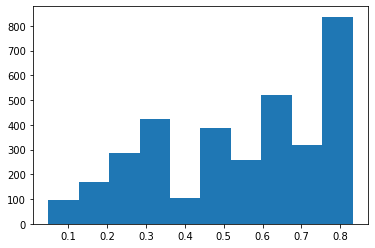

In [495]:
# Predicting results
y_pred = clf.predict_proba(X_test)

# Visualizing distribution of probability
plt.hist(y_pred[:,1])

In [699]:
# Aggregating distribution of probability by intervals of 10 percentile 
result = pd.DataFrame(columns=["num_recepients","conversion"],dtype=np.float)
for i in range(90,0,-10):
    threshold = np.percentile(y_pred[:,1], i)
    num_recepients = np.sum(y_pred[:,1] >= threshold)
    num_completed = np.sum(y.loc[X_test.index][y_pred[:,1] >= threshold])
    conv_ratio = num_completed / num_recepients
    result = result.append(pd.DataFrame({"num_recepients":num_recepients, "conversion":conv_ratio},index=[i]))

result

,num_recepients,conversion,num_recepients %
90,415.0,0.819277,0.122059
80,800.0,0.827500,0.235294
70,1154.0,0.803293,0.339412
60,1411.0,0.771793,0.415000
50,1862.0,0.733620,0.547647
40,2062.0,0.717265,0.606471
30,2424.0,0.674917,0.712941
20,2822.0,0.631467,0.830000
10,3134.0,0.589343,0.921765


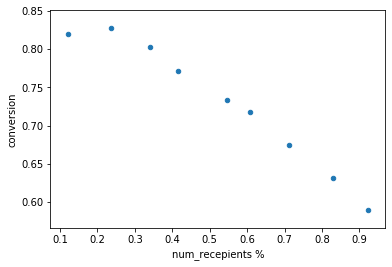

In [555]:
result["num_recepients %"] = result["num_recepients"]/3400

result.plot.scatter(x="num_recepients %",y="conversion")

If we send offers to only **top 10%** of customers(90 percentile), conversion rate will be **81.9%**.  
On the other hand, if we send offers to half(**50%**) of customers, conversion rate will drop dwon to **73.4%**. The number will decrease along with number of receipients increase.